In [78]:
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import medfilt
import numpy as np
import pandas as pd
import netCDF4 as nc
plt.rcParams.update({
    "text.usetex": True,                # Enable LaTeX text rendering
    "font.family": "serif",             # Use a serif font
    "font.serif": ["Computer Modern"],  # Set font to Computer Modern (LaTeX default)
})
sys.path.append('../src/')
from Biologging_Toolkit.applications.Jerk import Jerk
import warnings
warnings.filterwarnings("ignore")

In [13]:
depid = 'ml17_280a'
ds_path = '/run/media/grosmaan/LaCie/individus_brut/individus'
annotation_path = '/run/media/grosmaan/LaCie/drift_dives_SES/'

In [21]:
ds = nc.Dataset(os.path.join(path, depid, depid+'_sens.nc'))
dive = pd.read_csv(os.path.join(path, depid, depid+'_dive.csv'))
annot = pd.read_csv(os.path.join(annotation_path, depid, 'timestamps.csv'))

In [31]:
dives = ds['dives'][:].data
jerks = ds['jerk'][:].data
total_jerk = [np.sum(jerks[dives == dive]) for dive in np.unique(dives)]
dive['total_jerk'] = total_jerk

In [70]:
def successive_detections(series):
    changes = series.diff().fillna(0)
    starts = changes == 1 
    ends = changes == -1
    cumulative = series.cumsum() 
    lengths = cumulative[ends].diff().fillna(cumulative[ends]) 
    result = np.zeros_like(series)
    result[ends[ends].index] = lengths.values
    return pd.Series(result, index=series.index)

In [71]:
annot_pos = np.searchsorted(dive.begin_time, annot.start_drift)-1
annotations = {'ABW':np.zeros(len(dive)), 
               'Cachalot':np.zeros(len(dive)), 
               'SW':np.zeros(len(dive)), 
               'HW':np.zeros(len(dive)),
               'FW':np.zeros(len(dive)),
               'MW':np.zeros(len(dive))}
idx = 2
for i, row in annot.iterrows() :
    det = row[['Annotation', 'Annotation2', 'Annotation3']].to_numpy()
    conf = row[['Indice', 'Indice2', 'Indice3']].to_numpy()
    det = det[conf >= idx]
    for _det in det :
        if _det in ['Antarctic blue whale', 'Dcall'] :
            annotations['ABW'][annot_pos[i]] = 1
        elif _det=='Minke whale':
            annotations['MW'][annot_pos[i]] = 1
        elif _det=='Spermwhale':
            annotations['Cachalot'][annot_pos[i]] = 1
        elif _det=='Fin whale':
            annotations['FW'][annot_pos[i]] = 1
        elif _det=='Humpback whale':
            annotations['HW'][annot_pos[i]] = 1
        elif _det=='Sei whale':
            annotations['SW'][annot_pos[i]] = 1
annotations = pd.DataFrame(annotations)
for key in list(annotations.keys()) :
    dive[key] = successive_detections(annotations[key])

In [ ]:
plt.figure(figsize=(12, 8))
m = Basemap(
    projection="merc",
    llcrnrlat=40.6, urcrnrlat=40.8,
    llcrnrlon=-74.1, urcrnrlon=-73.9,
    resolution="i",
)
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color="lightgray", lake_color="aqua")
m.drawmapboundary(fill_color="aqua")
x, y = m(df["longitude"].values, df["latitude"].values)
m.scatter(x, y, s=sizes, color="blue", alpha=0.6)
plt.title("Trajectory with Scatter Points")
plt.show()

Text(0, 0.5, 'Number of recordings with detection')

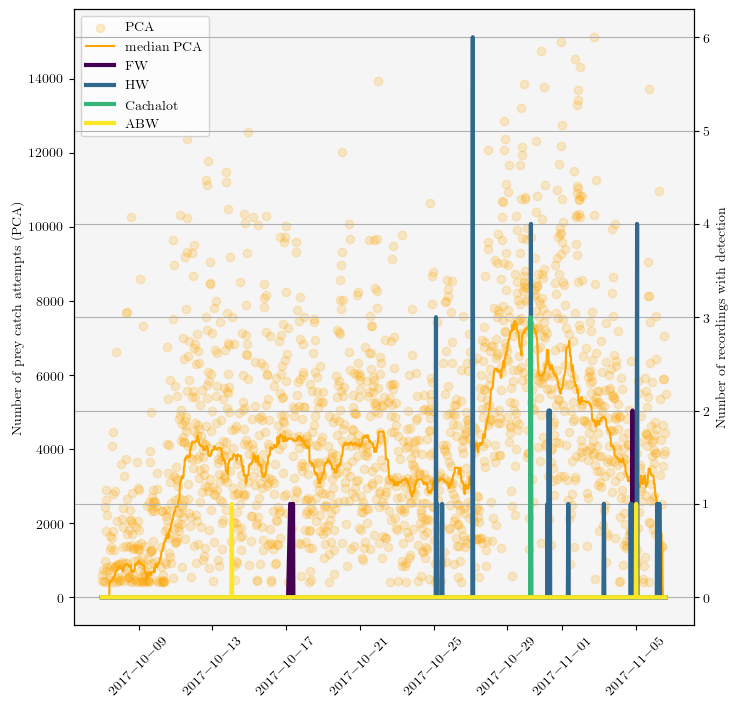

In [143]:
fig, ax = plt.subplots(figsize = (8, 8))
dive["begin_time"] = pd.to_datetime(dive["begin_time"], unit="s")
columns = list(dive[annotations.columns].sum()[dive[annotations.columns].sum() > 0].index)
colors = colormaps.get_cmap('viridis').resampled(len(columns))
ax1 = ax.twinx()
ax.scatter(dive.begin_time[dive.total_jerk > 0], dive.total_jerk[dive.total_jerk > 0], 
           alpha = 0.2, c = 'orange', label = 'PCA')
ax.plot(dive.begin_time, medfilt(dive.total_jerk, 101), c = 'orange', label = 'median PCA')
for i, elem in enumerate(columns[::-1]) :
    if dive[elem].sum() == 0 :
        continue
    ax1.plot(dive.begin_time, dive[elem], c = colors(i), linewidth = 3, label = elem)
ax.set_facecolor('whitesmoke')
ax1.grid()
ax.tick_params(axis='x', rotation=45)
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
legend = ax.legend(handles_ax + handles_ax1, labels_ax + labels_ax1, loc="upper left")
ax.set_ylabel("Number of prey catch attempts (PCA)")
ax1.set_ylabel("Number of recordings with detection")

In [ ]:
fig.savefig("")